In [1]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

from itertools import count
from collections import namedtuple
from torch.autograd import Variable

In [2]:
gamma_rl = 0.99

In [3]:
from gridworld import GridworldEnv

In [4]:
env = GridworldEnv(shape=(5, 5))

In [5]:
#state_dim = 2 * len(env.state)
state_dim = int(env.nS * 2)
action_dim = int(env.nA)

hidden_layer1_size = 50
hidden_layer2_size = 50

lambda_baseline = 0.1 #best 0.1

entropy_weights = {
    "Alice":0.0,
    "Bob":0.00,
}

eps = 1e-3

In [171]:
def set_random_s0(env):
    #rand_s0 = np.random.randint(12, 13)
    rand_s0 = np.random.randint(1, env.nS - 1)
    
    for i in range(len(env.isd)):
        env.isd[i] = 0
    
    env.isd[rand_s0] = 1  

In [174]:
class Alice:
    def __init__(self, Alice_type):
        self.type = Alice_type
    
    def get_action_probs(self, env, s):
        if(self.type == 'left_top_corner'):
            if(s == 0):
                return np.array([0, 0, 0, 0, 1])
            if(s % int(np.sqrt(env.nS)) == 0):
                return np.array([1, 0, 0, 0, 0])
            if(s < int(np.sqrt(env.nS))):
                return np.array([0, 0, 0, 1, 0])
            return np.array([0.5, 0, 0, 0.5, 0])
        else:
            if(s == env.nS - 1):
                return np.array([0, 0, 0, 0, 1])
            if((s + 1) % int(np.sqrt(env.nS)) == 0):
                return np.array([0, 0, 1, 0, 0])
            if(s + int(np.sqrt(env.nS)) >= env.nS):
                return np.array([0, 1, 0, 0, 0])
            return np.array([0, 0.5, 0.5, 0, 0])

    def select_action(self, env, s):
        action_probs = self.get_action_probs(env, s)
        action = np.random.choice(np.arange(5), p=action_probs)
        
        return action
    
    def get_state_action_distr(self, env, s):
        action_probs = self.get_action_probs(env, s)
        
        return action_probs
    
    def precompute_v_function(self, env):
        self.v = np.zeros(env.nS)
        for s in range(len(self.v)):
            if(self.type == 'left_top_corner'):
                self.v[s] = -(s % int(np.sqrt(env.nS)) + s // int(np.sqrt(env.nS)))
            else:
                self.v[s] = (-((int(np.sqrt(env.nS)) - (s % int(np.sqrt(env.nS))) - 1) 
                        + (int(np.sqrt(env.nS)) - s // int(np.sqrt(env.nS)) - 1)))

    def v_function(self, s):
        return self.v[s]

class Bob:
    def __init__(self, env):
        self.action_probs = [np.ones(4) * 0.25 for i in range(env.nS)]
        
    def select_action(self, s):
        action = np.random.choice(np.arange(4), p=action_probs[s])
        return action

    def change_state_action_distr(self, s, distr):
        self.action_probs[s] = distr

In [175]:
def is_done(env, s):
    return (s == env.nS - 1) or (s == 0)

def get_episode_reward(env, model, who, tmax,  s_star=None):
    policy_episode_reward = 0.0
    set_random_s0(env)
    env.reset()
    s = env.s
    gamma_factor = 1
    for i in range(tmax):
        if(is_done(env, s)):
            break
        if(who == "Alice"):
            a = model.select_action(env, s)
        else:
            a = model.select_action(s, s_star, cache_action=False)[0, 0]
        s, reward, _, _= env.step(a)
        policy_episode_reward += reward * gamma_factor
        gamma_factor *= gamma_rl
    
    return policy_episode_reward
        
        
def get_policy_reward_estimation(env, model, who, episodes_to_estimate, tmax, s_star=None):
    episode_reward_estiomation = []
    
    for ep in range(episodes_to_estimate):
        episode_reward_estiomation.append(get_episode_reward(env, model, who, tmax, s_star))
    
    return np.array(episode_reward_estiomation)

In [176]:
Alice_left_corner = Alice("left_top_corner")
Alice_left_corner.precompute_v_function(env)
Alice_right_corner = Alice("right_bottom_corner")
Alice_right_corner.precompute_v_function(env)

In [177]:
model_Bob = Bob(env)

In [178]:
def dummy_self_play_episode(env, n_step, model_Alice, model_Bob, pretraining_type="Repeat", is_gridworld=True):
    
    tA = 0
    done = False
    while True:
        tA = tA + 1
        s = env.s
        
        a = model_Alice.select_action(env, s)
        action_distr = model_Alice.get_state_action_distr(env, s)
        model_Bob.change_state_action_distr(s, action_distr[:4])
        if a == env.action_space.n or tA >= n_step:
            if(pretraining_type == "Repeat"):
                s_star = env.s# + 1
                env.reset()
            
            break
        state, _, done, _= env.step(a)

In [179]:
from tqdm import tnrange
from random import choice

def choose_Alice(models_Alice, s0, strategy="dummy"):
    if(strategy == "dummy"):
        return models_Alice[np.random.randint(len(models_Alice))]
    if(strategy == "v-based"):
        best_Alice_indxs = []
        best_Alice_v = -np.inf
        
        for i, Alice in enumerate(models_Alice):
            if(Alice.v_function(s0) > best_Alice_v):
                best_Alice_indx = [i]
                best_Alice_v = Alice.v_function(s0)
            if(Alice.v_function(s0) == best_Alice_v):
                best_Alice_indx.append(i)
                
        return models_Alice[choice(best_Alice_indx)]

from collections import defaultdict
    
def pretrain_model(env, nsteps, models_Alice, model_Bob, total_episodes, pretraining_type="Repeat"):
    rewards = []
    episode_time = []
    finish_states = []
    Alices_times_choice = defaultdict(int)
    for i in range(total_episodes):
        #print("Episode %d:" % (i + 1))
        set_random_s0(env)
        s0 = env.reset()# + 1
        model_Alice = choose_Alice(models_Alice, s0, strategy="v-based")
        Alices_times_choice[model_Alice.type] += 1
        
        dummy_self_play_episode(env, nsteps, model_Alice, model_Bob, pretraining_type)
    
    print(Alices_times_choice)
    return model_Bob

In [180]:
models_Alices = [Alice_left_corner, Alice_right_corner]

In [181]:
import copy
models_Bob = [copy.deepcopy(model_Bob)]

In [182]:
models_Bob.append(pretrain_model(env, 1, models_Alices, copy.deepcopy(model_Bob), 1000))
models_Bob.append(pretrain_model(env, 2, models_Alices, copy.deepcopy(model_Bob), 1000))
models_Bob.append(pretrain_model(env, 5, models_Alices, copy.deepcopy(model_Bob), 1000))

defaultdict(<class 'int'>, {'left_top_corner': 544, 'right_bottom_corner': 456})
defaultdict(<class 'int'>, {'left_top_corner': 512, 'right_bottom_corner': 488})
defaultdict(<class 'int'>, {'left_top_corner': 538, 'right_bottom_corner': 462})


In [183]:
models_Bob[0] == models_Bob[1]

False

In [184]:
models_Bob[0].action_probs[5]

array([ 0.25,  0.25,  0.25,  0.25])

Populating the interactive namespace from numpy and matplotlib


/Users/andrejklimkin/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'choice']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


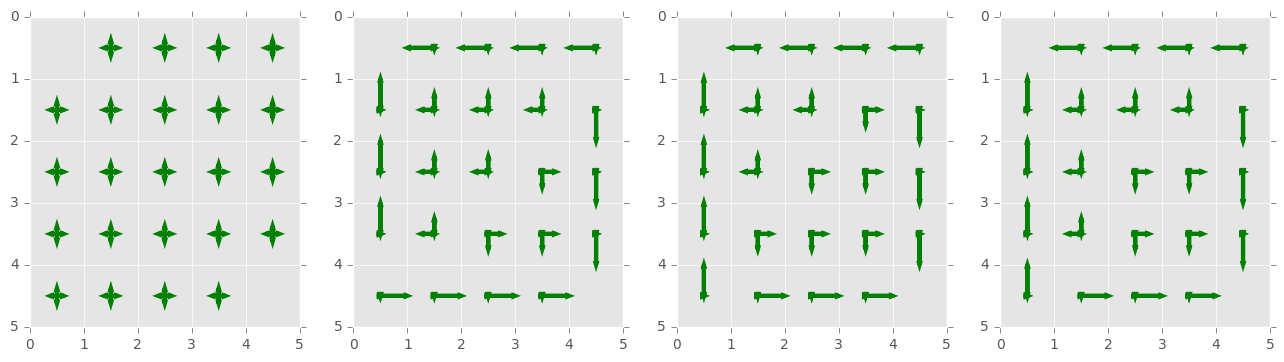

In [185]:
%pylab inline
import matplotlib

def draw_direction_probs(ax, env, s, p, scale_arrow=0.5, arrow_width=3, arrow_color='c', eps=1e-5):
    i = (s) // env.shape[1]
    j = (s) % env.shape[1]
    
    ax.arrow(j + 0.5, i + 0.5, p[1] * scale_arrow + eps, 0, linewidth=arrow_width, color=arrow_color, length_includes_head=True)
    ax.arrow(j + 0.5, i + 0.5, 0, p[2] * scale_arrow + eps, linewidth=arrow_width, color=arrow_color, length_includes_head=True)
    ax.arrow(j + 0.5, i + 0.5, -p[3] * scale_arrow + eps, 0, linewidth=arrow_width, color=arrow_color, length_includes_head=True)
    ax.arrow(j + 0.5, i + 0.5, 0, -p[0] * scale_arrow + eps, linewidth=arrow_width, color=arrow_color, length_includes_head=True)

    
matplotlib.style.use("ggplot")
fig, ax = subplots(nrows=1, ncols=4, figsize=(16, 4))
heat_map = np.zeros((5, 5))
heat_map[0][0] += 1
heat_map[4][4] += 1
#ax[1].set_xticks(np.arange(0, 6))
#ax[1].set_yticks(np.arange(0, 6))
#ax[0].gca().invert_yaxis()
#ax[1].gca().invert_yaxis()

#ax.arrow(0 + 0.5, 0 + 0.5, 0, -1, linewidth=5, color='c', length_includes_head=True)
for i, Bob_model in enumerate(models_Bob):
    ax[i].set_xticks(np.arange(0, 6))
    ax[i].set_yticks(np.arange(0, 6))
    for s in range(0, env.nS):
        if(s == 0 or s == 24):
            continue
        else:
            draw_direction_probs(ax[i], env, s, Bob_model.action_probs[s], arrow_color='green')
    ax[i].invert_yaxis()

#ax[0].set_title("First Alice", fontsize=11)
#ax[1].set_title("Second Alice", fontsize=11)
#plt.savefig("presa_example")